In [1]:
import warnings
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from dotenv import load_dotenv
from omegaconf import OmegaConf
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformer_lens import HookedTransformer, HookedTransformerConfig

sys.path.append(f'{os.getcwd()}/../')
from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from utils import heatmap_uncertainty

from metrics import (
    EM_compute,
    has_answer, # InAcc
    F1_compute,
)
load_dotenv()

[nltk_data] Downloading package treebank to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
nq_dataset = pd.read_csv('../data/adaptive_rag_natural_questions.csv')
wiki_dataset = pd.read_csv('../data/adaptive_rag_2wikimultihopqa.csv')
hotpot_dataset = pd.read_csv('../data/adaptive_rag_hotpotqa.csv')
musique_dataset = pd.read_csv('../data/adaptive_rag_musique.csv')

nq_dataset_test = pd.read_csv('../data/adaptive_rag_natural_questions_test.csv')
wiki_dataset_test = pd.read_csv('../data/adaptive_rag_2wikimultihopqa_test.csv')
hotpot_dataset_test = pd.read_csv('../data/adaptive_rag_hotpotqa_test.csv')
musique_dataset_test = pd.read_csv('../data/adaptive_rag_musique_test.csv')

In [3]:
ds = pd.concat([nq_dataset, wiki_dataset, hotpot_dataset, musique_dataset, 
    nq_dataset_test, wiki_dataset_test, hotpot_dataset_test, musique_dataset_test])
ds = ds.reset_index(drop=True)

train_indices, test_indices = train_test_split(list(ds.index), test_size=0.2, random_state=42)

In [4]:
preds_df = ds.iloc[test_indices].reset_index(drop=True)

In [5]:
cfg = OmegaConf.load("../config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

## QA Metrics

In [6]:
def call_rag(preds_df, preds, method_name):
    answers = []
    for index, pred_class in tqdm(enumerate(preds)):
        
        if pred_class == 0: # call rag and get context
            final_answer = preds_df.iloc[index]['our_answer_w_context']
        else: # answer is correct, do not call rag
            final_answer = preds_df.iloc[index]['our_answer_wo_context']

        answers.append(final_answer)
        
    preds_df[method_name] = answers
    return preds_df

# Logits before lm head

In [7]:
def store_activations(activation_dict):
    def hook_fn(activation, hook):
        activation_dict[hook.name] = activation.detach()
    return hook_fn

In [8]:
X = torch.empty((ds.shape[0], 3072), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0
activation_store = {}

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        # (1, seq_len, vocab_size)
        logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store)) 
                for i in range(model.cfg.n_layers)],
        )
    resid = activation_store[f"blocks.{27}.hook_resid_post"] # last hidden_state before lm head (1, seq_len, hidden_size)
    final_logits = resid[:, -1, :].squeeze(dim=0) # (vocab_size)

    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [04:34<00:00, 14.55it/s]


In [9]:
print(X.shape)
print(y.shape)

torch.Size([4000, 3072])
torch.Size([4000])


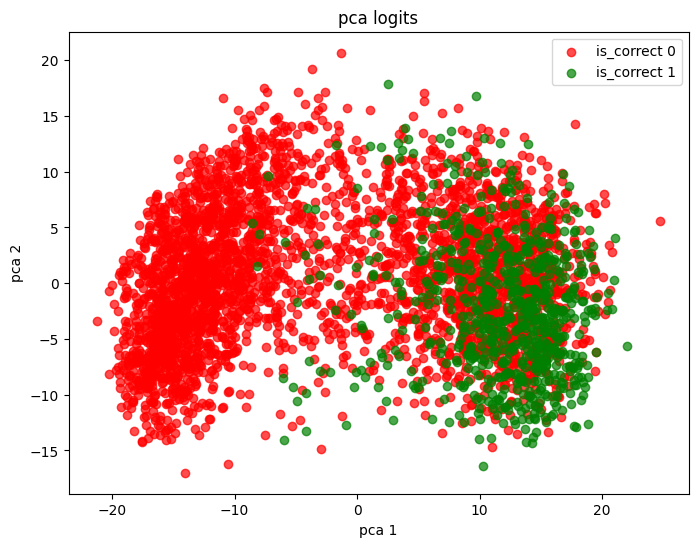

In [10]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

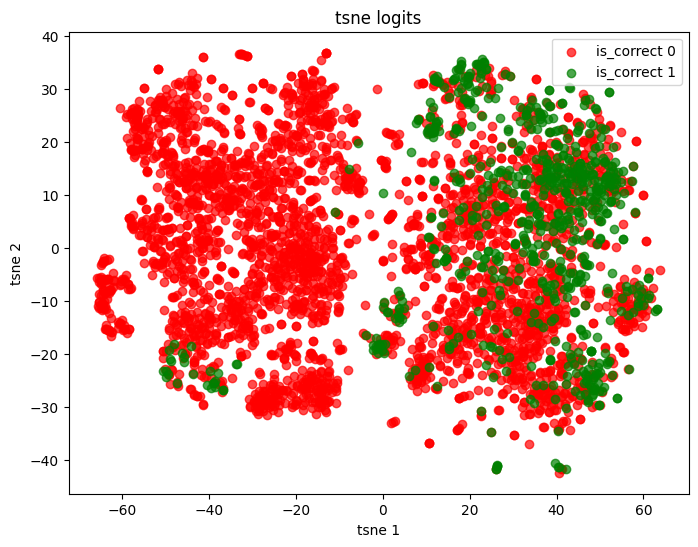

In [11]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## Unbalanced data + LogisticRegression

In [12]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [13]:
def y_proportion(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    total_elements = tensor.numel()
    proportions = counts.float() / total_elements
    return proportions

print(y_proportion(y))
print(y_proportion(y_train))
print(y_proportion(y_test))

tensor([0.8240, 0.1760])
tensor([0.8272, 0.1728])
tensor([0.8112, 0.1887])


In [14]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       649
           1       0.57      0.54      0.55       151

    accuracy                           0.83       800
   macro avg       0.73      0.72      0.73       800
weighted avg       0.83      0.83      0.83       800



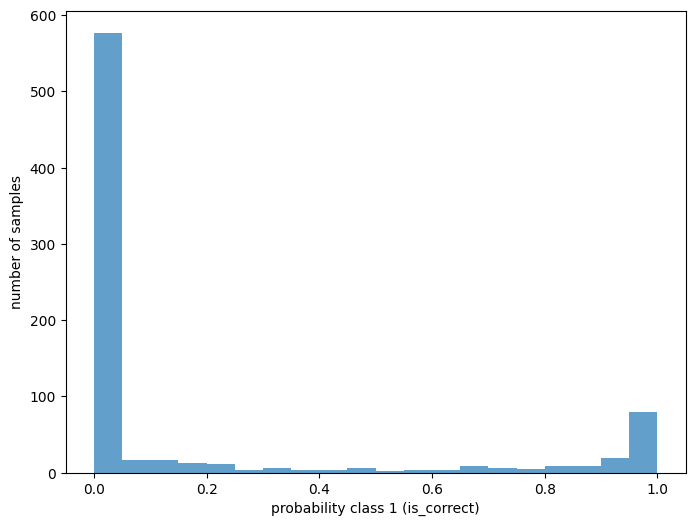

In [16]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [17]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_28_layer_resid_post_logits')

800it [00:00, 24532.04it/s]


## Downsampling + LogisticRegression

In [18]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

downsampled_class_0_indices = np.random.choice(class_0_indices, size=int(len(class_1_indices)*1.5), replace=False)
balanced_indices = np.concatenate([downsampled_class_0_indices, class_1_indices])
np.random.shuffle(balanced_indices)

X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [19]:
print('Before')
print(f'Num samples in train: {y_train.shape[0]}')
print(f'Distribution: {y_proportion(y_train)}')

print('After')
print(f'Num samples in train: {y_train_balanced.shape[0]}')
print(y_proportion(y_train_balanced))

Before
Num samples in train: 3200
Distribution: tensor([0.8272, 0.1728])
After
Num samples in train: 1382
tensor([0.5999, 0.4001])


In [20]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

In [21]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       649
           1       0.50      0.76      0.60       151

    accuracy                           0.81       800
   macro avg       0.72      0.79      0.74       800
weighted avg       0.85      0.81      0.82       800



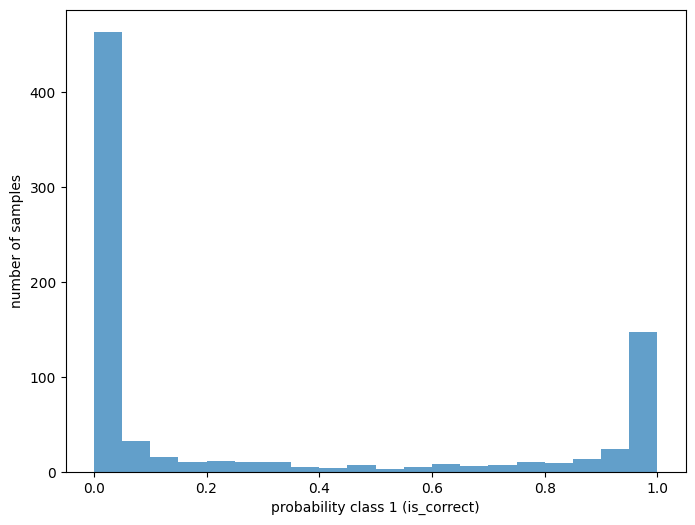

In [22]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [23]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_downsampling_28_layer_resid_post_logits')

800it [00:00, 26280.31it/s]


## MLP + bce + unbalanced data

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [25]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

y_train = y_train.float()
y_test = y_test.float()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{30}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4000
Epoch 2/30, Loss: 0.2978
Epoch 3/30, Loss: 0.2764
Epoch 4/30, Loss: 0.2633
Epoch 5/30, Loss: 0.2430
Epoch 6/30, Loss: 0.2316
Epoch 7/30, Loss: 0.2139
Epoch 8/30, Loss: 0.1990
Epoch 9/30, Loss: 0.1763
Epoch 10/30, Loss: 0.1505
Epoch 11/30, Loss: 0.1276
Epoch 12/30, Loss: 0.1053
Epoch 13/30, Loss: 0.0847
Epoch 14/30, Loss: 0.0690
Epoch 15/30, Loss: 0.0482
Epoch 16/30, Loss: 0.0341
Epoch 17/30, Loss: 0.0273
Epoch 18/30, Loss: 0.0181
Epoch 19/30, Loss: 0.0139
Epoch 20/30, Loss: 0.0101
Epoch 21/30, Loss: 0.0075
Epoch 22/30, Loss: 0.0060
Epoch 23/30, Loss: 0.0050
Epoch 24/30, Loss: 0.0045
Epoch 25/30, Loss: 0.0035
Epoch 26/30, Loss: 0.0029
Epoch 27/30, Loss: 0.0026
Epoch 28/30, Loss: 0.0024
Epoch 29/30, Loss: 0.0020
Epoch 30/30, Loss: 0.0017


In [26]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0.5).astype(int)

print(classification_report(y_test.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       649
         1.0       0.61      0.52      0.56       151

    accuracy                           0.85       800
   macro avg       0.75      0.72      0.73       800
weighted avg       0.84      0.85      0.84       800



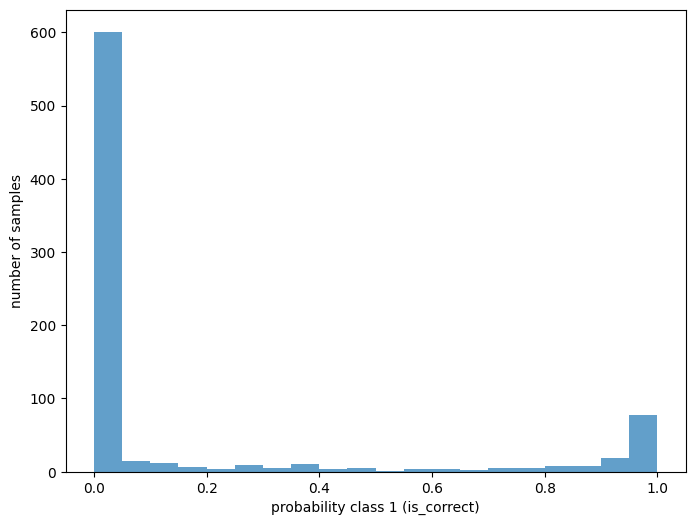

In [27]:
plt.figure(figsize=(8, 6))
plt.hist(logits_test, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [28]:
preds_df = call_rag(preds_df, y_pred, 'mlp_28_layer_resid_post_logits')

800it [00:00, 23024.44it/s]


## Hinge Loss MLP`+ unbalanced data

In [38]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [39]:
y_train_hinge = y_train * 2 - 1  # 0 -> -1, 1 -> 1
y_test_hinge = y_test * 2 - 1

train_dataset = TensorDataset(X_train, y_train_hinge)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.MarginRankingLoss(margin=1.0)
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X).squeeze()
        loss = criterion(logits, torch.zeros_like(logits), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/30, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.4349
Epoch 2/30, Loss: 0.3390
Epoch 3/30, Loss: 0.3224
Epoch 4/30, Loss: 0.3007
Epoch 5/30, Loss: 0.2848
Epoch 6/30, Loss: 0.2664
Epoch 7/30, Loss: 0.2430
Epoch 8/30, Loss: 0.2265
Epoch 9/30, Loss: 0.2007
Epoch 10/30, Loss: 0.1790
Epoch 11/30, Loss: 0.1572
Epoch 12/30, Loss: 0.1403
Epoch 13/30, Loss: 0.1146
Epoch 14/30, Loss: 0.0907
Epoch 15/30, Loss: 0.0777
Epoch 16/30, Loss: 0.0814
Epoch 17/30, Loss: 0.0460
Epoch 18/30, Loss: 0.0349
Epoch 19/30, Loss: 0.0245
Epoch 20/30, Loss: 0.0231
Epoch 21/30, Loss: 0.0208
Epoch 22/30, Loss: 0.0194
Epoch 23/30, Loss: 0.0104
Epoch 24/30, Loss: 0.0065
Epoch 25/30, Loss: 0.0046
Epoch 26/30, Loss: 0.0045
Epoch 27/30, Loss: 0.0026
Epoch 28/30, Loss: 0.0072
Epoch 29/30, Loss: 0.0038
Epoch 30/30, Loss: 0.0018


In [40]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       649
         1.0       0.61      0.44      0.51       151

    accuracy                           0.84       800
   macro avg       0.74      0.69      0.71       800
weighted avg       0.83      0.84      0.83       800



In [41]:
preds_df = call_rag(preds_df, y_pred, 'mlp_hinge_loss_28_layer_resid_post_logits')

800it [00:00, 22697.83it/s]


## AttentionPooling

In [42]:
class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()        
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Linear(d_model, 1),
            nn.ReLU(),
        )
        
    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w = w * attention_mask.unsqueeze(2)
        w = torch.softmax(w, 1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

# Logits from head

In [43]:
X = torch.empty((ds.shape[0], 128256), dtype=torch.float32)
y = torch.empty((ds.shape[0]), dtype=torch.int64)

idx = 0

for _, row in tqdm(ds.iterrows(), total=len(ds)):

    text = tokenizer.apply_chat_template([
        {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
    ], tokenize=False, add_generation_prompt=True)
    
    tokens = model.to_tokens(text, prepend_bos=False).to(device)
    with torch.no_grad():
        logits = model(tokens)  # (1, seq_len, vocab_size)
    
    final_logits = logits[:, -1, :].squeeze(dim=0) # (vocab_size)
    
    X[idx] = final_logits.cpu()
    y[idx] = int(row['is_correct_wo_context'])
    idx += 1

100%|██████████| 4000/4000 [05:58<00:00, 11.17it/s]


In [44]:
print(X.shape)
print(y.shape)

torch.Size([4000, 128256])
torch.Size([4000])


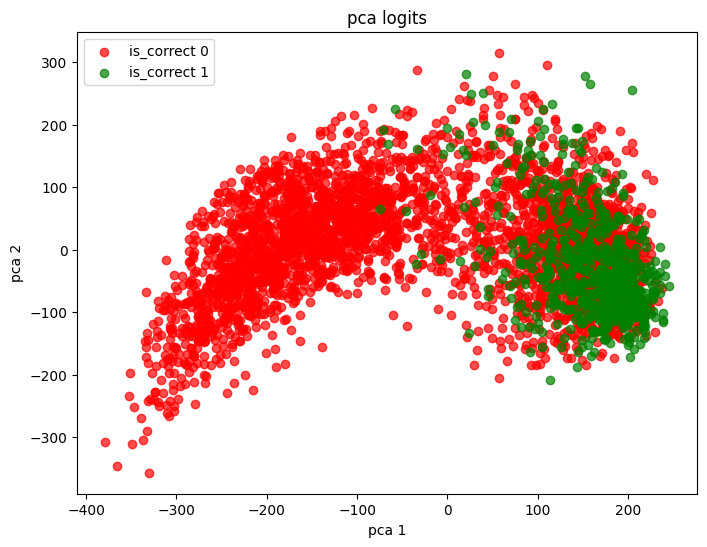

In [45]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

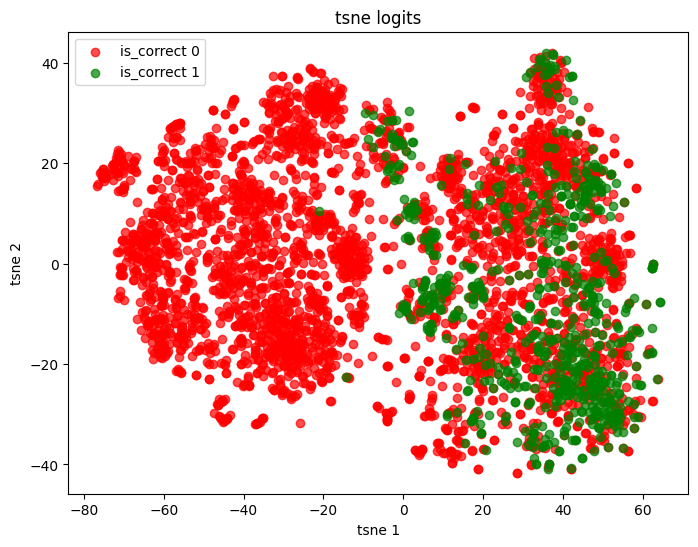

In [46]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

## Unbalanced data + LogisticRegression

In [47]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [48]:
def y_proportion(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    total_elements = tensor.numel()
    proportions = counts.float() / total_elements
    return proportions

print(y_proportion(y))
print(y_proportion(y_train))
print(y_proportion(y_test))

tensor([0.8240, 0.1760])
tensor([0.8272, 0.1728])
tensor([0.8112, 0.1887])


In [49]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       649
           1       0.53      0.52      0.53       151

    accuracy                           0.82       800
   macro avg       0.71      0.71      0.71       800
weighted avg       0.82      0.82      0.82       800



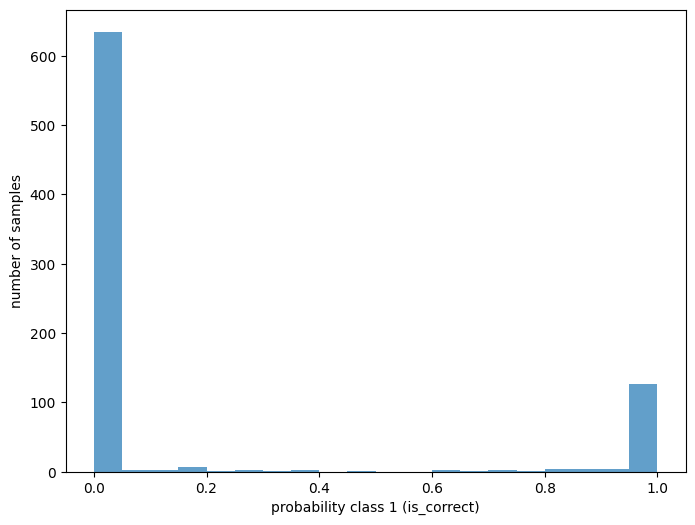

In [51]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [52]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_head_logits')

800it [00:00, 23372.78it/s]


## Downsampling + LogisticRegression

In [53]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

downsampled_class_0_indices = np.random.choice(class_0_indices, size=int(len(class_1_indices)*1.5), replace=False)
balanced_indices = np.concatenate([downsampled_class_0_indices, class_1_indices])
np.random.shuffle(balanced_indices)

X_train_balanced = X_train[balanced_indices]
y_train_balanced = y_train[balanced_indices]

In [54]:
print('Before')
print(f'Num samples in train: {y_train.shape[0]}')
print(f'Distribution: {y_proportion(y_train)}')

print('After')
print(f'Num samples in train: {y_train_balanced.shape[0]}')
print(y_proportion(y_train_balanced))

Before
Num samples in train: 3200
Distribution: tensor([0.8272, 0.1728])
After
Num samples in train: 1382
tensor([0.5999, 0.4001])


In [55]:
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [56]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       649
           1       0.50      0.76      0.60       151

    accuracy                           0.81       800
   macro avg       0.72      0.79      0.74       800
weighted avg       0.85      0.81      0.82       800



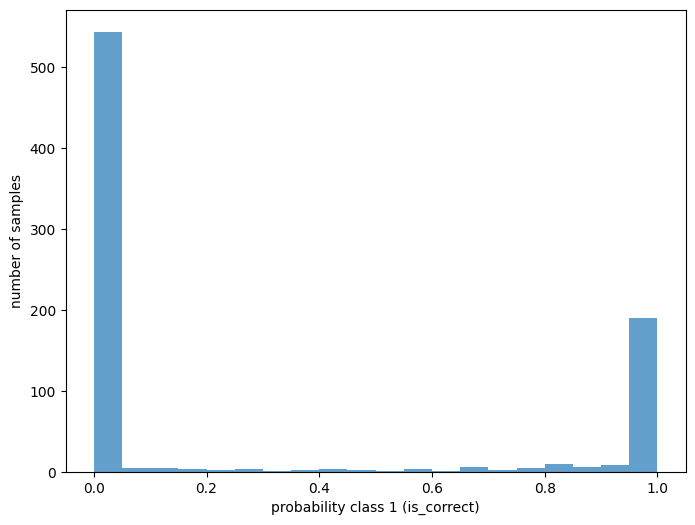

In [57]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [58]:
preds_df = call_rag(preds_df, y_pred, 'log_reg_downsampling_head_logits')

800it [00:00, 22454.20it/s]


## MLP + bce + unbalanced data

In [59]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [60]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

y_train = y_train.float()
y_test = y_test.float()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

mlp = MLP().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-4)

for epoch in range(30):
    mlp.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = mlp(batch_X)
        loss = criterion(logits.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{30}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30, Loss: 0.8317
Epoch 2/30, Loss: 0.2859
Epoch 3/30, Loss: 0.2664
Epoch 4/30, Loss: 0.2335
Epoch 5/30, Loss: 0.2185
Epoch 6/30, Loss: 0.1961
Epoch 7/30, Loss: 0.1928
Epoch 8/30, Loss: 0.1832
Epoch 9/30, Loss: 0.1588
Epoch 10/30, Loss: 0.1411
Epoch 11/30, Loss: 0.1381
Epoch 12/30, Loss: 0.1226
Epoch 13/30, Loss: 0.1013
Epoch 14/30, Loss: 0.1008
Epoch 15/30, Loss: 0.1216
Epoch 16/30, Loss: 0.1002
Epoch 17/30, Loss: 0.0655
Epoch 18/30, Loss: 0.0476
Epoch 19/30, Loss: 0.0411
Epoch 20/30, Loss: 0.0674
Epoch 21/30, Loss: 0.0592
Epoch 22/30, Loss: 0.0776
Epoch 23/30, Loss: 0.0478
Epoch 24/30, Loss: 0.0289
Epoch 25/30, Loss: 0.0227
Epoch 26/30, Loss: 0.0153
Epoch 27/30, Loss: 0.0150
Epoch 28/30, Loss: 0.0155
Epoch 29/30, Loss: 0.0075
Epoch 30/30, Loss: 0.0061


In [61]:
mlp.eval()
with torch.no_grad():
    logits_test = mlp(X_test.to(device)).cpu().numpy()
    y_pred = (logits_test > 0.5).astype(int)

print(classification_report(y_test.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90       649
         1.0       0.56      0.49      0.52       151

    accuracy                           0.83       800
   macro avg       0.72      0.70      0.71       800
weighted avg       0.82      0.83      0.83       800



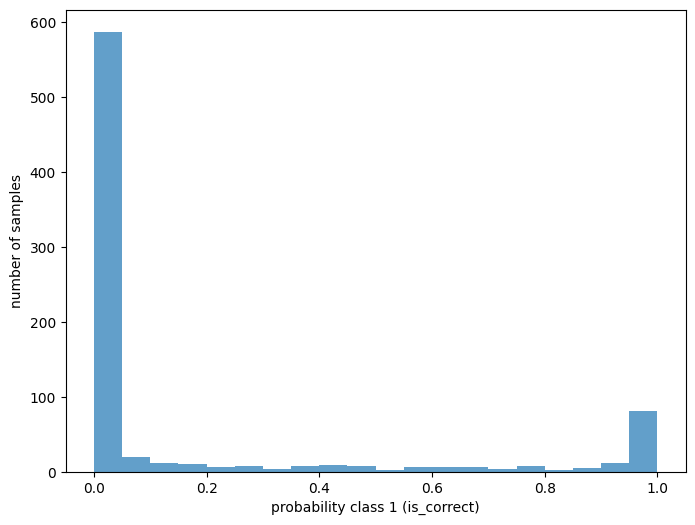

In [62]:
plt.figure(figsize=(8, 6))
plt.hist(logits_test, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

In [63]:
preds_df = call_rag(preds_df, y_pred, 'mlp_head_logits')

800it [00:00, 20245.83it/s]


## QA inference

In [64]:
def process_dataframe(df, pred_col, gt_col):
    has_answer_arr = []
    em_arr = []
    f1_arr = []
    
    for _, row in df.iterrows():
        prediction = row[pred_col]
        ground_truths = row[gt_col]

        has_ans = has_answer([ground_truths], prediction)
        em = EM_compute([ground_truths], prediction)
        f1 = F1_compute([ground_truths], prediction)
        
        has_answer_arr.append(has_ans)
        em_arr.append(em)
        f1_arr.append(f1)
    
    df['InAcc'] = has_answer_arr
    df['EM'] = em_arr
    df['F1'] = f1_arr
    
    mean_has_answer = np.mean(has_answer_arr) if has_answer_arr else 0
    mean_em = np.mean(em_arr) if em_arr else 0
    mean_f1 = np.mean(f1_arr) if f1_arr else 0

    return mean_has_answer, mean_em, mean_f1, df

In [68]:
rows = ["Never RAG", "Always RAG", "log_reg_head_logits", "log_reg_downsampling_head_logits", "mlp_head_logits", 'log_reg_28_layer_resid_post_logits', 'log_reg_downsampling_28_layer_resid_post_logits', 'mlp_28_layer_resid_post_logits', 'mlp_hinge_loss_28_layer_resid_post_logits']
columns = ["F1", "Exact Match", "InAcc"]
data = []

for row in rows:
    if row == "Never RAG":
        pred_col = 'our_answer_wo_context'
    elif row == "Always RAG":
        pred_col = 'our_answer_w_context'
    else:
        pred_col = row
        
    gt_col = 'reference'
   
    inacc_score, mean_em, mean_f1, _ = process_dataframe(preds_df, pred_col, gt_col)
    data.append([mean_f1, mean_em, inacc_score])
    
metrics_df = pd.DataFrame(data, index=rows, columns=columns)

In [69]:
metrics_df

,F1,Exact Match,InAcc
Never RAG,0.143977,0.04125,0.14250
Always RAG,0.555243,0.36500,0.56875
log_reg_head_logits,0.518220,0.32500,0.52750
log_reg_downsampling_head_logits,0.481808,0.29875,0.49125
mlp_head_logits,0.523671,0.33125,0.53250
log_reg_28_layer_resid_post_logits,0.514569,0.32125,0.52625
log_reg_downsampling_28_layer_resid_post_logits,0.479487,0.28750,0.48500
mlp_28_layer_resid_post_logits,0.527272,0.33250,0.53750
mlp_hinge_loss_28_layer_resid_post_logits,0.533104,0.34250,0.54750
